In [1]:
import path
import libs.checker as checker
from control import *
from z3 import *
from scipy.signal import lti, step
import scipy.signal as sig
from matplotlib import pyplot as p
import numpy

This example is borrowed and adapted from [1], advanced problem 5.9 on Pg. 359. Given a closed-loop system, which contains a PI controller:
$$ K_p + \frac{K_i}{s}$$
and a process:
$$\frac{1}{s(s+15)(s+25)}$$

The goal is to design the gains such that the dominant roots have a damping ratio of $\zeta$ equals to 0.707, and settling time (2% criterian) less than 5 seconds to a step input.

[1] Richard C.. Dorf, and Robert H. Bishop. Modern control systems. Pearson Prentice Hall, 2016. Pg. 359

By block diagram algebra, we obtain the following closed-loop function:

$$H(s) = \frac{K_p s + K_i}{s^4+40s^3+375s^2+K_p s + K_i} $$

By the problem constraints (i.e. the characteristic equation of H(s) need to have a dominent roots whose damping ratio = 0.707), we construct the following template:
$$H(s) = \frac{K_p s + K_i}{(s+a)(s+b)(s^2+\sqrt{2}\omega_n s + \omega_n^2)} $$

By aligning denominators, and constraints on the system:
 * $(s+a)(s+b)(s^2+\sqrt{2}\omega_n s + \omega_n^2) = s^4+40s^3+375s^2+K_p s + K_i$
 * $a, b >> \frac{\sqrt{2}}{2} \omega_n$ (to ensure root dominance)
 * $ t_s = - \frac{ln(0.02)}{\zeta \omega_n} < 5 $ (to ensure the desired settling time)

Tidy up constraints, we get:

 * $\omega_n^2 ab =  K_i $
 * $\omega_n^2(a+b) + \sqrt{2}\omega_n ab = K_p$
 * $\sqrt{2}\omega_n(a+b) + ab = 375$
 * $\sqrt{2}\omega_n + a + b = 40$
 * $a, b > 10*\frac{\sqrt{2}}{2} \omega_n$
 * $ \frac{3.91}{0.707 \omega_n} < 5$
 

In [2]:
# Constants

Kp = Real('Kp')
Ki = Real('Ki')
omega = Real('omega')
a, b = Reals('a b')
zeta = 0.707

# Setup
f1 = omega * omega * a * b == Ki
f2 = (a+b)*omega*omega+1.414*omega*a*b == Kp
f3 = 1.414*omega*(a+b)+a*b == 375
f4 = 1.414*omega + a + b == 40
f5 = And(a > 10*0.707*omega, b > 10*0.707*omega)
f6 = omega > 0
f7 = (-numpy.log(0.02) / (0.707 * omega)) < 5

f8 = And(f1,f2,f3,f4,f5,f6,f7) # we want solve satisfication problem instead of validity problem here

In [3]:
# Setup
c = checker.Checker(zeta,omega)
c.add(f8)


In [4]:
# Symbolic solving in Z3 SMT solver
c.result()


static checking result =  sat
static checking model =  [b = 11.4549197715?,
 a = 26.75,
 omega = 1.2695051120?,
 Kp = 611.6195752822?,
 Ki = 493.8382741642?,
 /0 = [(3.9120230054?, 0.8975401142?) -> 4.3586051960?,
       else -> 0]]


Numeric static checking suggests that the design with solved zeta and omega_n met the requirement on settling time:

In [5]:
zeta = zeta
omega_n = c.model(omega)
c2 = checker.Checker(zeta,omega_n)

f = c2.factory
f.sigma = 0.02
safety = f.settle < 5
c2.auto_pog(safety)
c2.result()

static checking result =  unsat


We now plot to double check:

In [6]:
# get model
v_omega = c.model(omega)
v_Kp = c.model(Kp)
v_Ki = c.model(Ki)

# Hs
Hs_num = [v_Kp, v_Ki]
Hs_den = [1, 40, 375, v_Kp, v_Ki]
Hs = lti(Hs_num, Hs_den)
t, s = step(Hs)

# Hs_hat
Hs_hat_num = [v_omega*v_omega]
Hs_hat_den = [1, 1.414*v_omega, v_omega*v_omega]
Hs_hat = lti(Hs_hat_num, Hs_hat_den)
t2, s2 = step(Hs_hat)


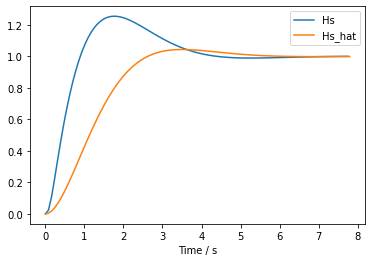

In [7]:
# plot

p.plot(t, s, label='Hs')
p.plot(t2,s2, label='Hs_hat')
p.xlabel('Time / s')
p.legend()
p.show()

From the figure, we see that both system roughly settled within 2% in less than 5 seconds. However, they behave different in the transient behaviors. This might due to the droping of high weight terms in Hs:

In [8]:
from scipy.signal import residue

r,p,k = residue(Hs_num, Hs_den)
print(f"weights = {r}")
print(f"poles = {p}")

weights = [ 1.13086901-0.01667968j  1.13086901+0.01667968j -3.78268701+0.j
  1.520949  -0.j        ]
poles = [ -0.90281761+0.8984358j  -0.90281761-0.8984358j -11.33253609+0.j
 -26.86182868+0.j       ]


As we can see, we dropped a pole at -11.33, whose weight (-3.78) is higher than the keeped pole at -0.9 (1.13).

In summary, we use time-domain metrics estimations to represent a hybrid system design as a satifiable problem to aid its design process. We then apply numeric checking on the finished design to ensure its validity. This hybrid static checking enrich the applicability of our approach.